#Libraries

In [ ]:
import pandas as pd
import numpy as np
import json, ast,time
import sys
from tqdm.notebook import tqdm
from scipy.stats import pearsonr, spearmanr,kendalltau
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

data_path = "<excel-file-path>"
results_path = "<plot-saving-path>"

# Reading Dataset

In [ ]:
'''
LLM1 - PalM2
LLM2 - GPT-3.5
LLM3 - Llama2
'''
data = pd.read_excel(data_path+"llm1_dataset.xlsx")
data.head()

# GPT4o Evaluation (Micro)

In [ ]:
%%capture
!pip install openai==0.28

In [ ]:
import openai

# openai.api_key = "<OPENAI-Key>" uncomment it

def get_gpt_output(inp, role='user', temp=0.0):
    message = [{'role': role, 'content': inp}]
    fail_count = 0

    while True:
        try:
            completion = openai.ChatCompletion.create(
                model="gpt-4o",
                messages=message,
                temperature=temp,
            )
            break
        except openai.error.RateLimitError as e:
            print(e)
            time.sleep(5)
        except openai.error.APIError as e:
            print(e)
            fail_count += 1
            if fail_count > 10:
                raise e
            time.sleep(5)
        except openai.error.ServiceUnavailableError as e:
            print(e)
            time.sleep(5)
        except openai.error.TimeoutError as e:
            print(e)
            time.sleep(5)

    reply_content = completion.choices[0].message.content
#     print('Reply: ', reply_content)

    return reply_content


In [ ]:
get_gpt_output("Tell me about yourself")

## Evaluation Prompt

In [ ]:

#Here, we will generate the ratings

all_dataframes = list()

for p in range(1,5):
    # time.sleep(5)
    ratings = list()
    for i in range(len(data)):
        r1 = data['Review1'][i]
        r2 = data['Review2'][i]
        r3 = data['Review3'][i]
        mr = data[f'res_prompt{p}'][i]


        prompt = f"""
        Imagine you are a human annotator evaluating the quality of meta-reviews written for a conference.  \
        You will evaluate five aspects of the meta-review by giving a value from 1 to 5, with 1 being the worst and 5 being the best, \
        without additional explanation. Please follow these steps:
         1. Carefully read the reviews, noting the key information they contain.
         2. Read the meta-review thoroughly.
         3. Rate the meta-review on the following five aspects using Precision (P) and Recall (R): \
                 - Core Contributions (CC)
                 - Common Strengths (CS)
                 - Common Weaknesses (CW)
                 - Suggestions for Improvement (SI)
                 - Missing References (MR)

         4. Provide your ratings on a scale from 1 (worst) to 5 (best) for each aspect in both Precision and Recall.


        Definitions are as follows:
        (1) Core Contributions (CC): Does the meta-review contain the contributions of the paper mentioned in multiple reviews?
        (2) Common Strengths (CS): Does the meta-review include all the strengths that are common across reviews?
        (3) Common Weaknesses (CW): Does the meta-review include all the weaknesses that are common in multiple reviews?
        (4) Suggestions for Improvement (SI): Does the meta-review include all the common suggestions for improvement mentioned in multiple reviews?
        (5) Missing References (MR): Does the meta-review include all the missing references mentioned in multiple reviews?


       Specific Questions for Rating:
        - CC-P: Is the meta-review precise in capturing the contributions of the paper highlighted by at least two reviews?
        - CC-R: Has the meta-review covered all the contributions of the paper, which are highlighted by at least two reviews?
        - CS-P: Is the meta-review precise in capturing the common strengths highlighted by at least two reviews?
        - CS-R: Has the meta-review covered all the common strengths highlighted by at least two reviews?
        - CW-P: Is the meta-review precise in capturing the common weaknesses highlighted by at least two reviews?
        - CW-R: Has the meta-review covered all the common weaknesses highlighted by at least two reviews?
        - SI-P: Is the meta-review precise in capturing the suggestions highlighted by at least two reviews?
        - SI-R: Has the meta-review covered all the suggestions highlighted by at least two reviews?
        - MR-P: Is the meta-review precise in capturing the missing references highlighted by at least two reviews?
        - MR-R: Has the meta-review covered all the missing references highlighted by at least two reviews?

        Please give the ratings in numerical form for each aspect in two categories without including the aspect names.


        Now complete the task for the given reviews(r1,r2,r3) and  meta-review delimited by triple backticks.
        Review 1: ```{r1}```
        Review 2: ```{r2}```
        Review 3: ```{r3}```
        Meta Review: ```{mr}```
        The output should be in a list [CC-P, CC-R, CS-P, CS-R, CW-P, CW-R, SI-P, SI-R, MR-P, MR-R] where you give only the ratings and don't include the aspect name.

        """

        response = get_gpt_output(prompt)
        convert_list = ast.literal_eval(response) # convert generated response into dictionary
        ratings.append(convert_list) # add it to qa list
        print(f"prompt:{p}", f"paper: {i+1}", response)
    d = pd.DataFrame(ratings)
    d.columns = [f'LLM3P{p}[CC-P]',f'LLM3P{p}[CC-R]',f'LLM3P{p}[CS-P]',f'LLM3P{p}[CS-R]',f'LLM3P{p}[CW-P]',f'LLM3P{p}[CW-R]',
                                   f'LLM3P{p}[SI-P]',f'LLM3P{p}[SI-R]',f'LLM3P{p}[MR-P]',f'LLM3P{p}[MR-R]']
    all_dataframes.append(d)

In [ ]:
final_df = pd.concat(all_dataframes,axis = 1, ignore_index=False)
final_df.shape

(40, 40)

In [ ]:
# save the ratings into excel file
# do the same for each LLM
final_df.to_excel(data_path + "GPT-rating_LLM1.xlsx",index = False)

# Helper Functions (Plot)

In [ ]:
# pivot where we averaged the P and R
def corr_pivot(dataset):
    index = list(dataset.index)
    # Filter out elements containing '-R' and replace '-P' with ''
    new_index = [item.replace('-P', '') for item in index if '-R' not in item]

    dataframes = list()
    for col in dataset:
        average = dataset[col].rolling(2).mean().iloc[1::2].reset_index(drop=True)
        new_df = pd.DataFrame({col: average})
        dataframes.append(new_df)

    # make dataframe
    new_df = pd.concat(dataframes,axis=1)
    new_df['Labels'] = new_index

    # Extract Prompt and Category
    new_df['Prompt']   = 'P' + new_df['Labels'].str.extract(r'P(\d)')
    new_df['Category'] = new_df['Labels'].str.extract(r'\[(\w{2})\]')

    # Pivot the DataFrame
    df_pivot = new_df.pivot(index='Prompt', columns='Category', values='Pearson').reset_index()
    df = pd.melt(df_pivot, id_vars='Prompt', var_name="Category", value_name="Values")

    return df

In [ ]:
# pivot where we have only CC, CW and so on values
def corr_pivot_new(dataset):
    dataset['Labels'] = list(dataset.index)

    # Extract Prompt and Category
    dataset['Prompt']   = 'P' + dataset['Labels'].str.extract(r'P(\d)')
    dataset['Category'] = dataset['Labels'].str.extract(r'\[(\w{2})\]')

    # Pivot the DataFrame
    df_pivot = dataset.pivot(index='Prompt', columns='Category', values='Pearson').reset_index()
    df = pd.melt(df_pivot, id_vars='Prompt', var_name="Category", value_name="Values")
    return df

In [ ]:
def corr_plot(df, plt_name, y_limit, save = False):

    model_names = ['P1', 'P2','P3', 'P4']
    plt.figure(figsize=(4, 2))

    # bar plot
    splot = sns.barplot(data=df,x='Prompt', y='Values' ,hue='Category',palette="pastel")


    # Define some hatches
    hatches = ['//','','\\','','.']

    # Loop over the bars and apply hatches cyclically
    for i, thisbar in enumerate(splot.patches):
        hatch = hatches[(i // 4) % len(hatches)] # Cycle through hatches
        thisbar.set_hatch(hatch)

    # plt.title(plt_name)
    plt.xlabel('Prompt')
    plt.ylabel('Correlation')
    plt.ylim(y_limit)
    ax = plt.gca()
    ax.spines['bottom'].set_color("gray")
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    handles, labels = splot.get_legend_handles_labels()
    for handle, hatch in zip(handles, hatches):
      handle.set_hatch(hatch)  # Apply the same hatch pattern to the legend entries

    # Adjust legend to horizontal and reduce gaps between legend items
    plt.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1, 0.5), shadow=True,
               ncol=1, fontsize=8, handletextpad=0.5, columnspacing=0.8, handlelength=1.5, handleheight=1.2)
    plt.tight_layout()  # Ensures all elements fit within the figure area
    # plt.xticks([0,1,2,3],model_names ,rotation = '0')
    if save:
      plt.savefig(results_path+f'{plt_name}.png',dpi = 400,bbox_inches ='tight')

In [ ]:
# bar plot
def corr_plot_no_legend(df,plt_name,y_limit,save = False):
  plt.figure(figsize=(3, 2))
  splot = sns.barplot(data=df,x='Labels', y='Values',palette="pastel")

      # Define some hatches
      #hatches = ['//','','x','','-']
  hatches = ['//','','\\','','.']

  # Loop over the bars and apply hatches cyclically
  for i, thisbar in enumerate(splot.patches):
      hatch = hatches[i] # Cycle through hatches
      thisbar.set_hatch(hatch)

  # plt.title(plt_name)
  plt.xlabel('Evaluatioon Aspect')
  plt.ylabel('Correlation')

  plt.ylim(y_limit)
  # for some plots
  y_ticks = np.arange(y_limit[0], y_limit[1] + 0.06, 0.06)  # Create ticks from 0 to 0.15 with a step size of 0.03
  plt.yticks(y_ticks)
  #####
  ax = plt.gca()
  ax.spines['bottom'].set_color("gray")
  ax.spines['left'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  plt.tight_layout()  # Ensures all elements fit within the figure area
  # plt.xticks([0,1,2,3],model_names ,rotation = '0')
  if save:
    plt.savefig(results_path+f'{plt_name}.png',dpi = 400,bbox_inches ='tight')

#Correlation (averaging Likert Scores)

In [ ]:
data = pd.read_excel(data_path + "GPT-rating_LLM1.xlsx")
hum_eval = data[data['Eval_Type'] == 'Human']
gpt_eval = data[data['Eval_Type'] == 'GPT']

In [ ]:
hum_eval.head(5)

,Paper#,Accepted/ Rejected,Eval_Type,LLM1P1[CC-P],LLM1P1[CC-R],LLM1P1[CS-P],LLM1P1[CS-R],LLM1P1[CW-P],LLM1P1[CW-R],LLM1P1[SI-P],...,LLM1P4[CC-P],LLM1P4[CC-R],LLM1P4[CS-P],LLM1P4[CS-R],LLM1P4[CW-P],LLM1P4[CW-R],LLM1P4[SI-P],LLM1P4[SI-R],LLM1P4[MR-P],LLM1P4[MR-R]
40,P1,Accepted,Human,1,1,2,2,3,3,5,...,4,4,3,4,4,4,3,4,3,4
41,P2,Rejected,Human,3,4,2,2,3,4,3,...,2,4,2,4,2,4,2,4,3,4
42,P3,Accepted,Human,4,4,4,4,2,3,1,...,2,4,2,4,2,3,2,4,3,4
43,P4,Accepted,Human,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
44,P5,Accepted,Human,5,5,2,5,1,5,5,...,5,5,2,5,1,5,1,5,5,5


In [ ]:
gpt_eval.head(5)

In [ ]:
hum_eval.columns

In [ ]:
# Average the P and R Scores
col_names = ['LLM1P1[CC]', 'LLM1P1[CS]', 'LLM1P1[CW]','LLM1P1[SI]', 'LLM1P1[MR]',
       'LLM1P2[CC]', 'LLM1P2[CS]', 'LLM1P2[CW]',  'LLM1P2[SI]','LLM1P2[MR]',
        'LLM1P3[CC]', 'LLM1P3[CS]', 'LLM1P3[CW]', 'LLM1P3[SI]', 'LLM1P3[MR]',
      'LLM1P4[CC]',  'LLM1P4[CS]', 'LLM1P4[CW]', 'LLM1P4[SI]', 'LLM1P4[MR]']
# col_names

new_df = pd.DataFrame()
for i in range(3, 43, 2):

  new_df[f'Avg_{i//2+1}'] = np.floor(data.iloc[:, i:i+2].mean(axis=1)) # can do ciel instead of floor

new_df.columns  = col_names

In [ ]:
df = data[['Paper#', 'Accepted/ Rejected', 'Eval_Type']]
new_df = pd.concat([df, new_df], axis=1)
new_df

In [ ]:
# Separate human and automatic evaluations
human_scores = new_df[new_df['Eval_Type'] == 'Human'].drop(columns=['Eval_Type', 'Paper#','Accepted/ Rejected'])
auto_scores = new_df[new_df['Eval_Type'] == 'GPT'].drop(columns=['Eval_Type', 'Paper#','Accepted/ Rejected'])

# Ensure the order of papers is the same
assert all(new_df[new_df['Eval_Type'] == 'Human']['Paper#'].values == new_df[new_df['Eval_Type'] == 'GPT']['Paper#'].values)

# Calculate correlation for each aspect
correlations_aspect = {'Pearson': [], 'Spearman': [], 'Kendall': []}

# Calculate correlation for each aspect
correlations = {}
for column in human_scores.columns:
    human_column_scores = human_scores[column]
    auto_column_scores = auto_scores[column]
    pearson_corr, _ = pearsonr(human_column_scores, auto_column_scores)
    spearman_corr, _ = spearmanr(human_column_scores, auto_column_scores)
    kendall_corr, _ = kendalltau(human_column_scores, auto_column_scores)

    correlations[column] = {
        'Pearson': pearson_corr,
        'Spearman': spearman_corr,
        'Kendall': kendall_corr
    }

# Convert to DataFrame for better visualization
correlation_df = pd.DataFrame(correlations).T
print(correlation_df)

             Pearson  Spearman   Kendall
LLM1P1[CC]  0.565302  0.410835  0.368288
LLM1P1[CS]  0.377914  0.269666  0.241625
LLM1P1[CW]  0.360645  0.285784  0.257201
LLM1P1[SI]  0.266676  0.194126  0.166496
LLM1P1[MR]  0.049571 -0.012862 -0.008884
LLM1P2[CC]  0.450404  0.151490  0.135450
LLM1P2[CS]  0.406916  0.274351  0.244066
LLM1P2[CW]  0.289695  0.112469  0.098446
LLM1P2[SI]  0.346827  0.209800  0.189031
LLM1P2[MR]  0.278385  0.282816  0.256008
LLM1P3[CC]  0.276827  0.028923  0.023484
LLM1P3[CS]  0.303096  0.182334  0.168476
LLM1P3[CW]  0.074881  0.027550  0.023544
LLM1P3[SI]  0.040730  0.002224  0.000000
LLM1P3[MR] -0.106120 -0.033762 -0.033039
LLM1P4[CC]  0.525298  0.382622  0.356157
LLM1P4[CS]  0.369749  0.280576  0.259847
LLM1P4[CW]  0.090610  0.055618  0.051213
LLM1P4[SI]  0.409307  0.369525  0.335793
LLM1P4[MR]  0.353124  0.326199  0.290770


In [ ]:
# correlation_df.to_excel(data_path+'corr_average_likert_floor.xlsx',sheet_name = 'PalM2',index = True)

In [ ]:
## Save the ratings for each LLM changing the sheet name
file_name = data_path+'corr_average_likert_floor.xlsx'
# Add a new sheet to an existing Excel file
with pd.ExcelWriter(file_name, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    # Save the modified DataFrame to a new sheet
    correlation_df.to_excel(writer, sheet_name = 'Llama2', index = True)

##Correlation Plots

In [ ]:
# Correlations GPT4o vs Human
# ceil means we average the likert scroes for P and R then take the ceil ouptut
corr_llm1_c = pd.read_excel(data_path + 'corr_average_likert_ceil.xlsx',sheet_name = 'PalM2',index_col=0)
corr_llm2_c = pd.read_excel(data_path + 'corr_average_likert_ceil.xlsx',sheet_name = 'GPT-3.5',index_col=0)
corr_llm3_c = pd.read_excel(data_path + 'corr_average_likert_ceil.xlsx',sheet_name = 'Llama2',index_col=0)

In [ ]:
# pivot for llms
# making format for plot
pivot_llm1_c = corr_pivot_new(corr_llm1_c)
pivot_llm2_c = corr_pivot_new(corr_llm2_c)
pivot_llm3_c = corr_pivot_new(corr_llm3_c)

In [ ]:
corr_llm1_c

### Correlation PalM2

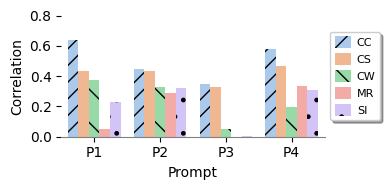

In [ ]:
# correlation for LLM1
corr_plot(pivot_llm1_c,'Correlation for PalM2',y_limit=[0,0.8],save = True)

**Observation**

- Overall correlation is good in all aspect for Prompt 2.
- In case of Prompt 1, correlation with MR is very poor.
- Correlation is very poor with CW, MR, and SI in case of Prompt-3 [need to perform a case study]



In [ ]:
# Calculate the average value for each prompt
all_prompt = pivot_llm1_c.groupby(pivot_llm1_c.index // 4).agg({'Values': 'mean'})
all_prompt['Labels'] = ['CC','CS','CW','MR','SI']
all_prompt

,Values,Labels
0,0.502167,CC
1,0.414439,CS
2,0.238135,CW
3,0.135784,MR
4,0.215559,SI


In [ ]:
palm2_all_prompt = all_prompt
palm2_all_prompt['Cateogory'] = 'PalM2'

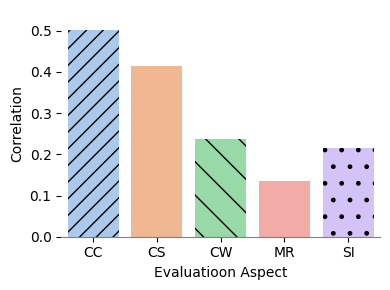

In [ ]:
# # correlation for LLM1 aggregrate prompt level
corr_plot_no_legend(all_prompt,'Correlation-PalM2 [Prompt Levels]',y_limit=[0,0.55], save = True)

### Correlation GPT-3.5

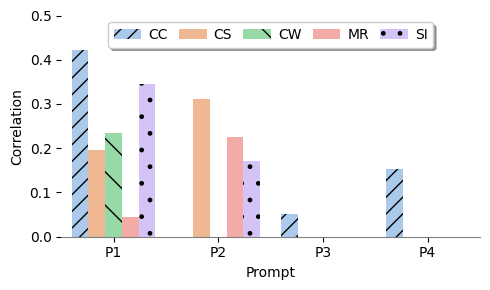

In [ ]:
# correlation for LLM2
corr_plot(pivot_llm2_c,'Correlation for GPT-3.5',y_limit=[0,0.5],save = True)

In [ ]:
# Calculate the average value for each prompt
all_prompt = pivot_llm2_c.groupby(pivot_llm2_c.index // 4).agg({'Values': 'mean'})
all_prompt['Labels'] = ['CC','CS','CW','MR','SI']
all_prompt

,Values,Labels
0,0.136566,CC
1,0.041507,CS
2,0.014897,CW
3,0.021520,MR
4,0.068239,SI


In [ ]:
gpt_all_prompt = all_prompt
gpt_all_prompt['Cateogory'] = 'GPT-3.5'

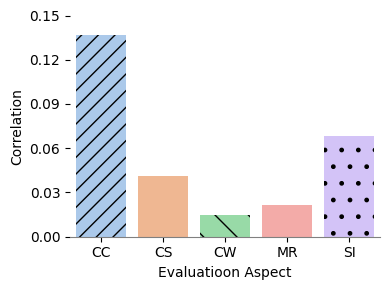

In [ ]:
# # correlation for LLM1 aggregrate prompt level
corr_plot_no_legend(all_prompt,'Correlation-GPT-3.5 [Prompt Levels]',[0,0.15],save = True)

### Correlation Llama2

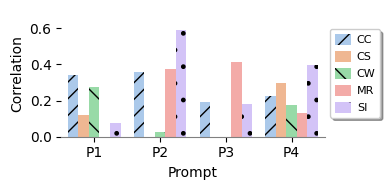

In [ ]:
# correlation for LLM3
corr_plot(pivot_llm3_c,'Correlation for Llama2',y_limit=[0,0.7],save = False)

In [ ]:
# Calculate the average value for each prompt
all_prompt = pivot_llm3_c.groupby(pivot_llm3_c.index // 4).agg({'Values': 'mean'})
all_prompt['Labels'] = ['CC','CS','CW','MR','SI']
all_prompt

,Values,Labels
0,0.278757,CC
1,0.070633,CS
2,0.105020,CW
3,0.195439,MR
4,0.310172,SI


In [ ]:
llama_all_prompt = all_prompt
llama_all_prompt['Cateogory'] = 'Llama2'

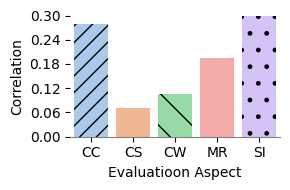

In [ ]:
# # correlation for LLM1 aggregrate prompt level
corr_plot_no_legend(all_prompt,'Correlation-Llama2 [Prompt Levels]',[0,0.3],save = True)

### Correlation Across Prompt Levels for ALL LLMs

In [ ]:
all = pd.concat([palm2_all_prompt,gpt_all_prompt,llama_all_prompt],axis = 0)
all

In [ ]:
# Define custom sort order
custom_order = ['CC', 'CS', 'CW', 'SI', 'MR']

# Apply the custom sort order directly to the Labels column
all['Labels'] = pd.Categorical(all['Labels'], categories=custom_order, ordered=True)

# Sort the DataFrame based on Labels
df_sorted = all.sort_values(by=['Labels'])

# Display the sorted DataFrame
df_sorted

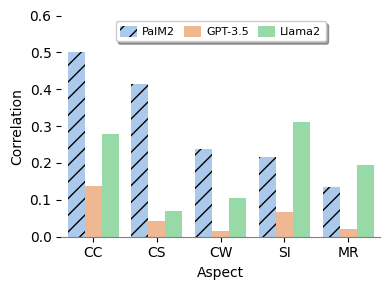

In [ ]:
model_names = ['CC', 'CS','CW', 'SI','MR']
plt.figure(figsize=(4, 3))

# bar plot
splot = sns.barplot(data=df_sorted,x='Labels', y='Values' ,hue='Cateogory',palette="pastel")

# Define some hatches
hatches = ['//',' ',' ']

# Loop over the bars and apply hatches cyclically
for i, thisbar in enumerate(splot.patches):
    hatch = hatches[(i // 5) % len(hatches)] # Cycle through hatches
    thisbar.set_hatch(hatch)

# plt.title(plt_name)
plt.xlabel('Aspect')
plt.ylabel('Correlation')
plt.ylim([0,0.6])
ax = plt.gca()
ax.spines['bottom'].set_color("gray")
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
handles, labels = splot.get_legend_handles_labels()
for handle, hatch in zip(handles, hatches):
    handle.set_hatch(hatch)  # Apply the same hatch pattern to the legend entries

# Adjust legend to horizontal and reduce gaps between legend items
plt.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5,1), shadow=True,
               ncol=3, fontsize=8, handletextpad=0.5, columnspacing=0.8, handlelength=1.5, handleheight=1.2)
plt.tight_layout()  # Ensures all elements fit within the figure area
# plt.xticks([0,1,2,3],model_names ,rotation = '0')
# if save:
plt.savefig(results_path+'prompt_all.png',dpi = 400,bbox_inches ='tight')